In [265]:
import os
import tensorflow as tf
#import keras
from keras.layers import Add,Multiply,Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector, Conv2D,ConvLSTM2D, MaxPooling2D,BatchNormalization,Flatten,Reshape,UpSampling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))
import tensorflow_probability as tfp
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import imageio
from tqdm import tqdm
import cv2
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow_addons as tfa
import psutil
import pickle

import PIL.Image as Image

import gc
from tensorflow.keras import backend as k


physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


gpus = tf.config.experimental.list_physical_devices('GPU')
#gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

/tmp/ipykernel_32425/3794690065.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display as html_width


In [266]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
print(tf.__version__)

['/device:CPU:0']
2.13.1


2025-03-20 13:13:17.721900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 13:13:17.721997: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [276]:
obs_min = 4
obs_max = 8
train_N = 49
train_p = np.random.permutation(50)
j = 0
x = 0
test_p = []
valid_p = []
print(train_p)

train_p_copy = train_p.copy()

for i in train_p_copy:
    if i <= 24 and j < 5:
        test_p.append(i)
        j += 1
        train_p = [item for item in train_p if item != i]  # Remove from train_p
    if i > 24 and x < 5:
        test_p.append(i)
        x += 1
        train_p = [item for item in train_p if item != i]  # Remove from train_p

print("Remaining train_p:", train_p)
print("test_p:", test_p)

# j = 0
# x = 0
# test_p_copy = test_p.copy()
# for i in test_p_copy:
#     if i < 25 and j < 3:
#         valid_p.append(i)
#         j += 1
#         test_p = [item for item in test_p if item != i]
#     if i > 25 and x < 2:
#         valid_p.append(i)
#         x += 1
#         test_p = [item for item in test_p if item != i] 
# print("valid_p:", valid_p)
# print("test_p:", test_p)

[37 28 36 49 24 13  0 25 41 17 16  7 21 29 12  3  4 40 23 34 45 44 42 26
 48 18 27  9 33  1 14 35 47 46 11 43 39  6  8  2 19 15 31 22  5 38 10 32
 30 20]
Remaining train_p: [41, 7, 21, 29, 12, 3, 4, 40, 23, 34, 45, 44, 42, 26, 48, 18, 27, 9, 33, 1, 14, 35, 47, 46, 11, 43, 39, 6, 8, 2, 19, 15, 31, 22, 5, 38, 10, 32, 30, 20]
test_p: [37, 28, 36, 49, 24, 13, 0, 25, 17, 16]


# Data Augmentation

In [ ]:
def augment_image(image, aug_prob=0.3):
    aug_image = image.copy()

    if np.random.rand() < aug_prob:

        if np.random.rand() < 0.35:
            crop_factor = np.random.uniform(0.5, 0.8) 
            aug_image = tf.image.central_crop(aug_image, crop_factor)

        aug_image = tf.image.resize(aug_image, (128, 128))

        if np.random.rand() < 0.35:
            aug_image = tf.image.random_brightness(aug_image, max_delta=0.2) 

        if np.random.rand() < 0.35:
            angles = tf.random.uniform([], minval=-0.26, maxval=0.6) 
            aug_image = tfa.image.rotate(aug_image, angles)

        if np.random.rand() < 0.35:
            translations = tf.random.uniform([2], minval=-10, maxval=10)
            aug_image = tfa.image.translate(aug_image, translations)

        # if np.random.rand() < 0.35:
        #     aug_image = tf.image.flip_left_right(aug_image)      
    else:
        aug_image = tf.image.resize(aug_image, (128, 128))

    return aug_image

def augment_touch_values(touch_values):
    if np.random.rand() < 0.3:  
        noise = np.random.normal(0, 0.005, size=touch_values.shape)  
        touch_values[touch_values > 0] = np.clip(touch_values[touch_values > 0] + noise[touch_values > 0], 0, 1)
    return touch_values

# Deep Modality Blending Networks

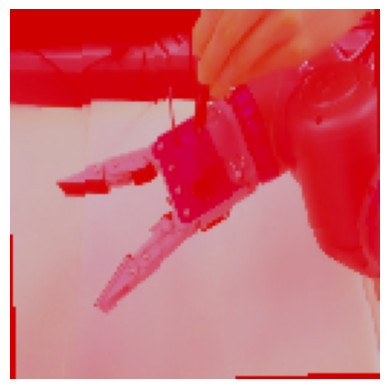

In [287]:
######################################################################### GET TRAIN SAMPLES ############################################################################

def get_train_sample(coef = -1):
    n = np.random.randint(obs_min, obs_max) + 1
    d = train_p[np.random.randint(0, 39)]
    
    if coef == -1:
         coef = np.random.uniform(0.2, 1.0)
    
    img_coef = np.ones((1, 128)) * coef
    touch_coef = np.ones((1, 128)) * (1 - coef)
    
    observation = np.zeros((1, n, 128, 128, 4)) 
    observation_touch = np.zeros((1, n, 9)) 
    target_X = np.zeros((1, 1))
    target_Y = np.zeros((1, 128, 128, 6))
    #target_Y_touch = np.zeros((1, 16))
    target_Y_touch = np.zeros((1, 8))
    
    pose = np.loadtxt('Data_Robot/%d/touch_data.txt' % d)
    time_len = pose.shape[0]
    times = np.linspace(0, 1, time_len)

    selected_indices = np.random.permutation(time_len)

    for i, idx in enumerate(selected_indices):
        if i < n -1:
            observation[0, i, :, :, 0] = np.ones((128, 128)) * times[idx]
            image = mpimg.imread('Data_Robot/%d/frame_%d.jpeg' % (d, idx))
            #image_resized = cv2.resize(image, (128, 128))
            augmented_image = augment_image(image)
            observation[0, i, :, :, 1:] = augmented_image 

            display.clear_output(wait=True)
            plt.imshow(observation[0, i, :, :, :3])
            plt.axis("off")
            plt.show()
            #print(observation[0, i, :, :, 1:])

            observation_touch[0, i, 0] = times[idx]
            observation_touch[0, i, 1:9] = augment_touch_values(pose[idx] / 255)
            # print(pose[idx] / 255)
            # print(observation_touch[0, i, 1:9])
            


    target_X[0, 0] = times[selected_indices[-1]]
    #print(target_X)
    t_img = mpimg.imread('Data_Robot/%d/frame_%d.jpeg' % (d, selected_indices[-1]))
    t_img_resize = cv2.resize(t_img, (128, 128))
    target_Y[0, :, :, :3] = t_img_resize 
    target_Y_touch[0, :8] = pose[selected_indices[-1]] / 255

    # display.clear_output(wait=True)
    # display.display(pl.gcf())
    # plt.imshow(target_Y[0,:,:,:3])
    # plt.show()


    #print (target_Y)

    return [observation, observation_touch, target_X, img_coef, touch_coef], [target_Y, target_Y_touch], d, selected_indices[-1], coef

inp, out, _, _, _ = get_train_sample()
# print(out)

######################################################################### GET VALIDATION SAMPLES ############################################################################


def get_valid_sample(): 
    n = np.random.randint(obs_min, obs_max) + 1
    d = valid_p[np.random.randint(0, 4)]

    coef = 1
    
    img_coef = np.ones((1, 128)) * coef
    touch_coef = np.ones((1, 128)) * (1 - coef)
    
    observation = np.zeros((1, n, 128, 128, 4)) 
    observation_touch = np.zeros((1, n, 9)) 
    target_X = np.zeros((1, 1))
    target_Y = np.zeros((1, 128, 128, 6))
    #target_Y_touch = np.zeros((1, 16))
    target_Y_touch = np.zeros((1, 8))
    
    pose = np.loadtxt('Data_Robot/%d/touch_data.txt' % d)
    time_len = pose.shape[0]
    times = np.linspace(0, 1, time_len)

    # Identify zero and nonzero rows
    zero_rows = np.where(np.all(pose == 0, axis=1))[0]
    nonzero_rows = np.where(np.any(pose != 0, axis=1))[0]
    
    if len(nonzero_rows) == 0 or len(zero_rows) == 0:
        raise ValueError("Dataset does not contain both zero and nonzero rows.")

    # Ensure at least one sample from each
    num_from_each = min(n // 2, len(nonzero_rows), len(zero_rows))
    selected_nonzero = np.random.choice(nonzero_rows, num_from_each, replace=False)
    selected_zero = np.random.choice(zero_rows, num_from_each, replace=False)

    remaining_samples = n - 2 * num_from_each
    if remaining_samples > 0:
        additional_samples = np.random.choice(time_len, remaining_samples, replace=False)
    else:
        additional_samples = np.array([], dtype=int)
    selected_indices = np.concatenate((selected_nonzero, selected_zero, additional_samples))
    np.random.shuffle(selected_indices)
    for i, idx in enumerate(selected_indices):
        if i < n -1:
            observation[0, i, :, :, 0] = np.ones((128, 128)) * times[idx]
            image = mpimg.imread('Data_Robot/%d/frame_%d.jpeg' % (d, idx))
            image_resized = cv2.resize(image, (128, 128))
            observation[0, i, :, :, 1:] = image_resized / 255

            observation_touch[0, i, 0] = times[idx]
            observation_touch[0, i, 1:9] = pose[idx] / 255

    target_X[0, 0] = times[selected_indices[-1]]
    t_img = mpimg.imread('Data_Robot/%d/frame_%d.jpeg' % (d, selected_indices[-1]))
    t_img_resize = cv2.resize(t_img, (128, 128))
    target_Y[0, :, :, :3] = t_img_resize / 255.
    target_Y_touch[0, :8] = pose[selected_indices[-1]] / 255

    return [observation, observation_touch, target_X, img_coef, touch_coef], [target_Y, target_Y_touch], d, selected_indices[-1]


########################################################################## GET TEST SAMPLES ####################################################################################


def get_test_sample(t,n, size):
    d = test_p[t]
    out = []
    #print(d)
    coef = 1
    img_coef = np.ones((1, 128)) * coef
    touch_coef = np.ones((1, 128)) * (1 - coef)

    observation = np.zeros((1, n, 128, 128, 4)) 
    observation_touch = np.zeros((1, n, 9)) 
    target_X = np.zeros((1, 1))
    
    pose = np.loadtxt('Data_Robot/%d/touch_data.txt' % d)
    time_len = pose.shape[0]
    times = np.linspace(0, 1, time_len)

    target_Y = np.zeros((1, 128, 128, 6))
    target_Y_touch = np.zeros((1, 8))

    for idx in range(size):
        if idx < n:
            observation[0, idx, :, :, 0] = np.ones((128, 128)) * times[idx]
            image = mpimg.imread('Data_Robot/%d/frame_%d.jpeg' % (d, idx))
            image_resized = cv2.resize(image, (128, 128))
            observation[0, idx, :, :, 1:] = image_resized 
            target_Y[0, :, :, :3] = image_resized 

            observation_touch[0, idx, 0] = times[idx]
            observation_touch[0, idx, 1:9] = pose[idx] / 255
            target_Y_touch[0, :8] = pose[idx] / 255
        else:
            t_img = mpimg.imread('Data_Robot/%d/frame_%d.jpeg' % (d, idx))
            t_img_resize = cv2.resize(t_img, (128, 128))
            target_Y[0, :, :, :3] = t_img_resize 
            target_Y_touch[0, :8] = pose[idx] / 255
        out.append([target_Y.copy(), target_Y_touch.copy()])

    target_X[0, 0] = times[n]

    return [observation, observation_touch, target_X, img_coef, touch_coef], out, idx, times

#inp, out, x, clock = get_test_sample(1,5,55)
#print(out[44][0])


In [270]:
@tf.keras.utils.register_keras_serializable()
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp =tf.split(y_true,2,axis=-1)
    #mean = tf.nn.relu(mean)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss


In [271]:
image_layer = Input(shape=(None,128,128,4), name="image_observation") 
touch_layer = Input(shape=(None,9), name="touch_observation") 
target_X_layer = Input(shape=(1,), name = 'target_X')
img_coef_layer = Input(shape=(128,), name = 'image_coef')
touch_coef_layer = Input(shape=(128,), name = 'touch_coef')

encoder_touch_sizes = [64,64,128,128,256]

touch_encoder = TimeDistributed(Dense(32, activation = 'relu'))(touch_layer)
for channel_size in encoder_touch_sizes:
    touch_encoder = TimeDistributed(Dense(channel_size, activation = 'relu'))(touch_encoder)

touch_representations = TimeDistributed(Dense(128, activation='relu'))(touch_encoder) #128
touch_representation = GlobalAveragePooling1D()(touch_representations) 

multiplied_touch = Multiply()([touch_representation,touch_coef_layer])

###################################################

encoder_img_sizes = [64,64,128,128,256]

image_encoder = TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu'))(image_layer)
image_encoder = TimeDistributed(MaxPooling2D((2,2)))(image_encoder)
for channel_size in encoder_img_sizes:
    image_encoder = TimeDistributed(Conv2D(channel_size,(3,3),padding='same',activation='relu'))(image_encoder)
    image_encoder = TimeDistributed(MaxPooling2D((2,2)))(image_encoder)

image_flatten = TimeDistributed(Flatten())(image_encoder)
img_representations = TimeDistributed(Dense(128, activation='relu'))(image_flatten)
img_representation = GlobalAveragePooling1D()(img_representations) 

multiplied_img = Multiply()([img_representation,img_coef_layer])

general_representation = Add()([multiplied_touch,multiplied_img])

merged_layer = Concatenate(axis=-1, name='merged')([general_representation,target_X_layer])

decoder_representation = Dense(1024, activation='relu') (merged_layer)

" =============== Image Decoder =============== "
decoder_img = Reshape([2,2,256])(decoder_representation)
decoder_img_sizes = [256,128,128,64,64,32]

for channel_size in decoder_img_sizes:
    decoder_img = Conv2D(channel_size, (3,3), padding='same', activation='relu')(decoder_img)
    decoder_img = UpSampling2D((2, 2))(decoder_img)

img_output = Conv2D(16, (3,3), padding='same', activation='relu')(decoder_img)
img_output = Conv2D(8, (3,3), padding='same', activation='relu')(img_output)
img_output = Conv2D(6, (3,3), padding='same', activation='sigmoid', name = "last_conv2d")(img_output)
" =============== Image Decoder =============== "

" =============== Touch Decoder =============== "
decoder_touch = Dense(512, activation='relu')(decoder_representation)
decoder_touch = Dense(216, activation='relu')(decoder_touch)
decoder_touch = Dense(128, activation='relu')(decoder_touch)
decoder_touch = Dense(32, activation='relu')(decoder_touch)
touch_output = Dense(8, activation='sigmoid', name="touch_values")(decoder_touch)

" =============== Touch Decoder =============== "

model = Model([image_layer, touch_layer, target_X_layer, img_coef_layer, touch_coef_layer],[img_output, touch_output])
latent_model = Model([image_layer, touch_layer, target_X_layer, img_coef_layer, touch_coef_layer],general_representation)
model.summary()
#plot_model(model)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_observation (InputLa  [(None, None, 128, 128, 4)   0         []                            
 yer)                        ]                                                                    
                                                                                                  
 time_distributed_28 (TimeD  (None, None, 128, 128, 32)   1184      ['image_observation[0][0]']   
 istributed)                                                                                      
                                                                                                  
 time_distributed_29 (TimeD  (None, None, 64, 64, 32)     0         ['time_distributed_28[0][0]'] 
 istributed)                                                                                

In [272]:

# initial_lr = 1e-4  
# lowered_lr = 1e-5 

# # Use this schedule in the optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)


model.compile(
    optimizer= Adam(lr = 1e-4),
    loss={
        'last_conv2d': custom_loss,  
        'touch_values': 'mse',  
    },
    loss_weights={
        'last_conv2d': 1,  
        'touch_values': 0.01, 
    },
    metrics={  # Add accuracy tracking
        'touch_values': ['mae'],  # Mean Absolute Error for touch values
    }  
)

In [ ]:
os.makedirs("Epochs_V9", exist_ok=True)

loss_checkpoint = 2000
plot_checkpoint = 1000
validation_checkpoint = 1000
validation_error = 9999999
validation_step = -1
max_training_step = 250000
t_inp = 10
data_size = 55
n_test = 10

dataset = ['image','touch']

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})

real_output = []
predict_output = []
touch_value_idx = 2
loss_history = [] 

for step in range(max_training_step):
    inp, out, _, _, coef = get_train_sample()
    #val_data, val_labels, _, _ = get_valid_sample()
    history = model.fit(inp, out, verbose=0) 
    loss_history.append(history.history['loss'][0])  

    if step % loss_checkpoint == 0 and step!= 0:
        path = f"Epochs_V9/Epoch{step}"
        os.makedirs(path, exist_ok=True)

        # Save model using pickle
        model.save(os.path.join(path, "model.keras"))

        # Save loss history
        with open(os.path.join(path, "loss_history.pkl"), "wb") as f:
            pickle.dump(loss_history, f)

        for test in range(n_test):
            step_predictions = []
            step_real_values = []
            step_absolute_errors_images = []
            step_squared_errors_images = []
            step_absolute_errors_touch = []
            step_squared_errors_touch = []


            test_inp, test_out, x, times = get_test_sample(test, t_inp, data_size)


            for i in range(t_inp, data_size-1):
                inp_copy = test_inp.copy() 
                inp_copy[2] = np.array([[times[i]]])
                pred = model.predict_on_batch(inp_copy)

                step_predictions.append(pred)
                step_real_values.append(test_out[i])


                pred_images = np.array(pred[0])
                pred_touch_values = np.array(pred[1])  

                out_images = np.array(test_out[i][0])  
                out_touch_values = np.array(test_out[i][1])  
            
                step_absolute_errors_images.append(np.abs(out_images - pred_images))  
                step_squared_errors_images.append((out_images - pred_images) ** 2) 

                step_absolute_errors_touch.append(np.abs(out_touch_values - pred_touch_values)) 
                step_squared_errors_touch.append((out_touch_values - pred_touch_values) ** 2) 


            del inp_copy, pred
    
            with open(os.path.join(path, f"predictions_{test}.pkl"), "wb") as f:
                pickle.dump(step_predictions, f)

            with open(os.path.join(path, f"real_values_{test}.pkl"), "wb") as f:
                pickle.dump(step_real_values, f)
    

            with open(os.path.join(path, f"absolute_errors_touch_{test}.pkl"), "wb") as f:
                pickle.dump(step_absolute_errors_touch, f)

            with open(os.path.join(path, f"squared_errors_touch_{test}.pkl"), "wb") as f:
                pickle.dump(step_squared_errors_touch, f)

                
            with open(os.path.join(path, f"absolute_errors_images_{test}.pkl"), "wb") as f:
                pickle.dump(step_absolute_errors_images, f)

            with open(os.path.join(path, f"squared_errors_images_{test}.pkl"), "wb") as f:
                pickle.dump(step_squared_errors_images, f)

            step_predictions.clear()
            step_real_values.clear()
            step_absolute_errors_images.clear()
            step_squared_errors_images.clear()
            step_absolute_errors_touch.clear()
            step_squared_errors_touch.clear()
            gc.collect()

    if step % 10000 == 0 and step != 0:
        gc.collect()
        k.clear_session()

            


KeyboardInterrupt: 